### Lab Task: Trading Agent for Smartphone Inventory Management  

**Goal:** Optimize stock levels and minimize costs.  

**Inputs:**  
1. **Price**: Smartphone price.  
2. **Stock**: Quantity in inventory.  

**Rules:**  
1. Order if **price drops ≥ 20%** or **stock < 10 units** or **both**
  - If **price < threshold** and **stock < 10**, order a specific quantity (e.g., 15 + 10 units).  
   - If **price < threshold** and **stock > 10**, order a specific quantity (e.g., 15 units).  
   - If **stock < 10**, order a minimum (e.g., 10 units).  
2. Otherwise, no order (tobuy = 0).  

**Example:**  
- Price drops to 500 BDT, stock = 20 → Order 15 units.  
- Stock = 5 → Order 10 units.  
- Neither → No order.  

In [3]:
import random
import math
import matplotlib.pyplot as plt

In [4]:
#Utilities

def argmaxall(gen):
    maxv = -math.inf
    maxvals = []
    for (e, v) in gen:
        if v > maxv:
            maxvals, maxv = [e], v
        elif v == maxv:
            maxvals.append(e)
    return maxvals

def argmaxe(gen):
    return random.choice(argmaxall(gen))

def argmax(lst):
    return argmaxe(enumerate(lst))

def argmaxd(dct):
   return argmaxe(dct.items())

def flip(prob):
    return random.random() < prob

def select_from_dist(item_prob_dist):
    ranreal = random.random()
    for (it, prob) in item_prob_dist.items():
        if ranreal < prob:
            return it
        else:
            ranreal -= prob
    raise RuntimeError(f"{item_prob_dist} is not a probability distribution")


In [5]:
#Display Class

class Displayable:
    max_display_level = 1

    def display(self, level, *args, **nargs):
        if level <= self.max_display_level:
            print(*args, **nargs)


In [6]:
class Plot_history:
    def __init__(self, ag, env):
        self.ag = ag
        self.env = env
        plt.ion()
        plt.xlabel("Time")
        plt.ylabel("Value")

    def plot_env_hist(self):
        num = len(env.stock_history)
        plt.plot(range(num), env.price_history, label="Price")
        plt.plot(range(num), env.stock_history, label="In stock")
        plt.legend()

    def plot_agent_hist(self):
        num = len(ag.buy_history)
        plt.bar(range(1, num + 1), ag.buy_history, label="Bought")
        plt.legend()

In [8]:
#Agent Conntroller

class Agent(Displayable):
    def initial_action(self, percept):
        return self.select_action(percept)

    def select_action(self, percept):
        raise NotImplementedError("select_action")


In [9]:
# Environment
class Environment(Displayable):
    def initial_percept(self):
        raise NotImplementedError("initial_percept")

    def do(self, action):
        raise NotImplementedError("Environment.do")

In [10]:
#Simulate
class Simulate(Displayable):
    def __init__(self, agent, environment):
        self.agent = agent
        self.env = environment
        self.percept = self.env.initial_percept()
        self.percept_history = [self.percept]
        self.action_history = []

    def go(self, n):
        for i in range(n):
            action = self.agent.select_action(self.percept)
            print(f"i={i} action={action}")
            self.percept = self.env.do(action, i)
            print(f"      percept={self.percept}")

In [12]:
#TP Env

class TP_env(Environment):
    price_delta = [0, 0, 0, 21, 0, 20, 0, -64, 0, 0, 23, 0, 0, 0, -35,
                   0, 76, 0, -41, 0, 0, 0, 21, 0, 5, 0, 5, 0, 0, 0, 5, 0,
                   -15, 0, 5, 0, 5, 0, -115, 0, 115, 0, 5, 0, -15, 0, 5,
                   0, 5, 0, 0, 0, 5, 0, -59, 0, 44, 0, 5, 0, 5, 0, 0, 0,
                   5, 0, -65, 50, 0, 5, 0, 5, 0, 0, 0, 5, 0]
    sd = 5

    def __init__(self):
        self.time = 0
        self.stock = 20
        self.stock_history = []
        self.price_history = []

    def initial_percept(self):
        self.stock_history.append(self.stock)
        self.price = round(234 + self.sd * random.gauss(0, 1))
        self.price_history.append(self.price)
        return {'price': self.price, 'instock': self.stock}

    def do(self, action, time_unit):
        used = select_from_dist({6: 0.1, 5: 0.1, 4: 0.1, 3: 0.3, 2: 0.2, 1: 0.2})
        bought = action['buy']
        self.stock = self.stock + bought - used
        self.stock_history.append(self.stock)
        self.time += 1
        self.price = round(self.price + self.price_delta[self.time % len(self.price_delta)]
                           + self.sd * random.gauss(0, 1))
        self.price_history.append(self.price)
        return {'price': self.price, 'instock': self.stock}



In [33]:
class TP_agent(Agent):
    def __init__(self):
        self.spent = 0
        percept = env.initial_percept()
        self.ave = self.last_price = percept['price']
        self.instock = percept['instock']
        self.buy_history = []

    def select_action(self, percept):
        self.last_price = percept['price']
        self.ave = self.ave + (self.last_price - self.ave) * 0.05
        self.instock = percept['instock']

        #conditions
        if self.last_price < 0.8 * self.ave and self.instock < 10:
            tobuy = 15 + 10
        elif self.last_price < 0.8 * self.ave:
            tobuy = 15
        elif self.instock < 10:
            tobuy = 10
        else:
            tobuy = 0

        self.spent += tobuy * self.last_price
        self.buy_history.append(tobuy)
        return {'buy': tobuy}


# the simulation
env = TP_env()
ag = TP_agent()
sim = Simulate(ag, env)

sim.go(18);


i=0 action={'buy': 0}
      percept={'price': 232, 'instock': 18}
i=1 action={'buy': 0}
      percept={'price': 237, 'instock': 15}
i=2 action={'buy': 0}
      percept={'price': 251, 'instock': 14}
i=3 action={'buy': 0}
      percept={'price': 253, 'instock': 12}
i=4 action={'buy': 0}
      percept={'price': 262, 'instock': 7}
i=5 action={'buy': 10}
      percept={'price': 263, 'instock': 14}
i=6 action={'buy': 0}
      percept={'price': 199, 'instock': 11}
i=7 action={'buy': 0}
      percept={'price': 199, 'instock': 8}
i=8 action={'buy': 10}
      percept={'price': 192, 'instock': 15}
i=9 action={'buy': 0}
      percept={'price': 214, 'instock': 13}
i=10 action={'buy': 0}
      percept={'price': 210, 'instock': 10}
i=11 action={'buy': 0}
      percept={'price': 209, 'instock': 5}
i=12 action={'buy': 10}
      percept={'price': 216, 'instock': 9}
i=13 action={'buy': 10}
      percept={'price': 180, 'instock': 16}
i=14 action={'buy': 15}
      percept={'price': 174, 'instock': 26}
i=15

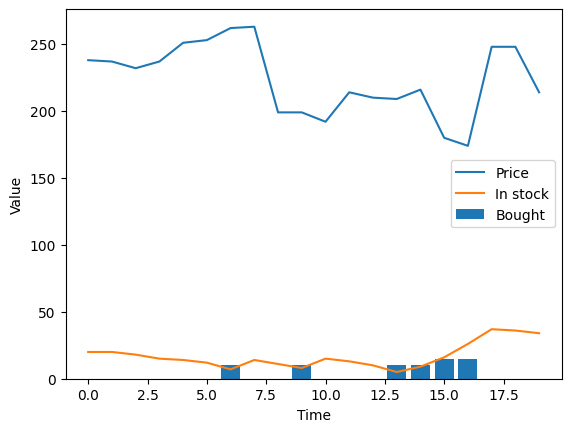

In [34]:
#the results
pl = Plot_history(ag, env)
pl.plot_env_hist()
pl.plot_agent_hist()
plt.show()